# A Daskified yt : reading data


## how yt works and how Dask can help
For discrete particle datasets, yt leverages several approaches to achieve efficient lazy loading of large datasets. When a user then reads in data, for example with code like 

```python
ds = yt.load_sample()
sp = ds.sphere(ds.domain_center, 0.25)
density = sp[("PartType0", "Density")]
```

yt will:

0. generate a spatial bitmap index for the dataset
1. use bitmap indexing to find data_files that overlap with a selection
2. iterate over the `data_files`, for each of `data_files`:
    a. open the file
    b. generate a mask using the selection object and a particle's coordinates 
    c. read the data, applying the mask
    

Step 0 is a one-time step for a dataset that uses Morton Indexing, a spatial bitmap-indexing algorithm, to efficiently map a regions of a physical domain to the data whether on-disk or elsewhere (cite yt4 paper, in prep). So as the first step of a selection, yt will first find the bitmap indices that intersect a selection object in order to quickly identify only those files that contain data within the selector and avoid reading datafiles unnecessarily. To further enhance read times, yt applies data selections at read to datafiles individually so that only data satisfying the selection criteria is returned (rather than reading the whole array into memory and then applying a selection).

This approach can be readily adapted to dask arrays in such a way that simplifies yt's code, particularly yt's frontend infrastructure. In yt, a frontend corresponds to data-specific methods for reading data. At present, implementing a new frontend requires writing an implementation of step 2 above, which requires some knowledge of yt's internal working (the data_files, selector objects) as well as knowledge of a frontend's native data structures (to read the raw data). With Dask, however, we can maintain the same efficiency while separating step 2 above into separate methods. 

In simplified pseudo-code, this looks like:


```python
def _read_particle_fields(self, fields, selector_obj, ):  

        # assemble the self.data_files that intersect the selector
        dfi, nfiles = self._identify_file_masks(dobj) 
        data_file_subset = [self.data_files[df_i] for df_i in dfi]

        # get a dask array where each chunk is a data_file
        data = self.io._read_from_datafiles(data_file_subset, fields_to_read) 
        
        # apply a selector object to each chunk of the dask array        
        data = self.apply_selector_mask(fields_to_return, selector_obj) # uses map_blocks function

        return data
```

where `read_from_datafiles` constructs dask arrays from delayed reads (again, pseudo-code):

```python
def _read_from_datafiles(data_files, fields_to_read):
    delayed_array = []
    for data_file in data_files:
        shape, dtype = self._get_data_file_ptype_counts(data_file, fields_to_read)
        vals = dask_delayed(frontend_read_particle_fields)(data_file, field_info)  # this is the actual io call
        delayed_array.append(dask_array.from_delayed(vals, shape, dtype=dtype))
    return dask.array.concatenate(delayed_array, axis=0)
```

What's nice about the above Daskified approach is that while `_read_particle_fields` is written linearly (read in data then apply selector to data) but because the data arrays here are dask arrays, the selector is applied by-chunk using `dask.array.map_blocks` so that we are **still** handling each chunk separately. This greatly simplifies frontend development: to write the io methods for a new frontend, one need only implement a function to read from a single `data_file` (called `frontend_read_particle_fields` above)! Additionally, we can directly return Dask arrays, allowing a user to easily analyize their data in parallel when yt does not already have an optimized option.



## Examples: simple reads and selections

These exmaples use the scipy2021 branch (see [setup](99_setup.html)) to load in a Gadget HDF5 dataset:

In [2]:
%%time
import yt 
ds = yt.load_sample("snapshot_033")
ad = ds.all_data()

yt : [INFO     ] 2021-06-25 15:36:48,317 Files located at /home/chris/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.
yt : [INFO     ] 2021-06-25 15:36:48,317 Default to loading snap_033.0.hdf5 for snapshot_033 dataset
yt : [INFO     ] 2021-06-25 15:36:48,404 Parameters: current_time              = 4.343952725460923e+17 s
yt : [INFO     ] 2021-06-25 15:36:48,405 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-06-25 15:36:48,405 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-06-25 15:36:48,406 Parameters: domain_right_edge         = [25. 25. 25.]
yt : [INFO     ] 2021-06-25 15:36:48,406 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-06-25 15:36:48,406 Parameters: current_redshift          = -4.811891664902035e-05
yt : [INFO     ] 2021-06-25 15:36:48,407 Parameters: omega_lambda              = 0.762
yt : [INFO     ] 2021-06-25 15:36:48,407 Parameters: omega_matter              = 0.238
yt : [

CPU times: user 2.9 s, sys: 184 ms, total: 3.09 s
Wall time: 3.08 s


In [4]:
%%time
field = ("PartType0","Density")
data = ad[field]
data

CPU times: user 143 µs, sys: 26 µs, total: 169 µs
Wall time: 175 µs


unyt_dask_array<mul, shape=(1941226,), dtype=float64, chunksize=(262144,), chunktype=numpy.ndarray, units=code_mass/code_length**3>

So we see we get back a unyt-dask array with 9 chunks nearly instantaneously. And those 9 chunks are nicely parallelized:

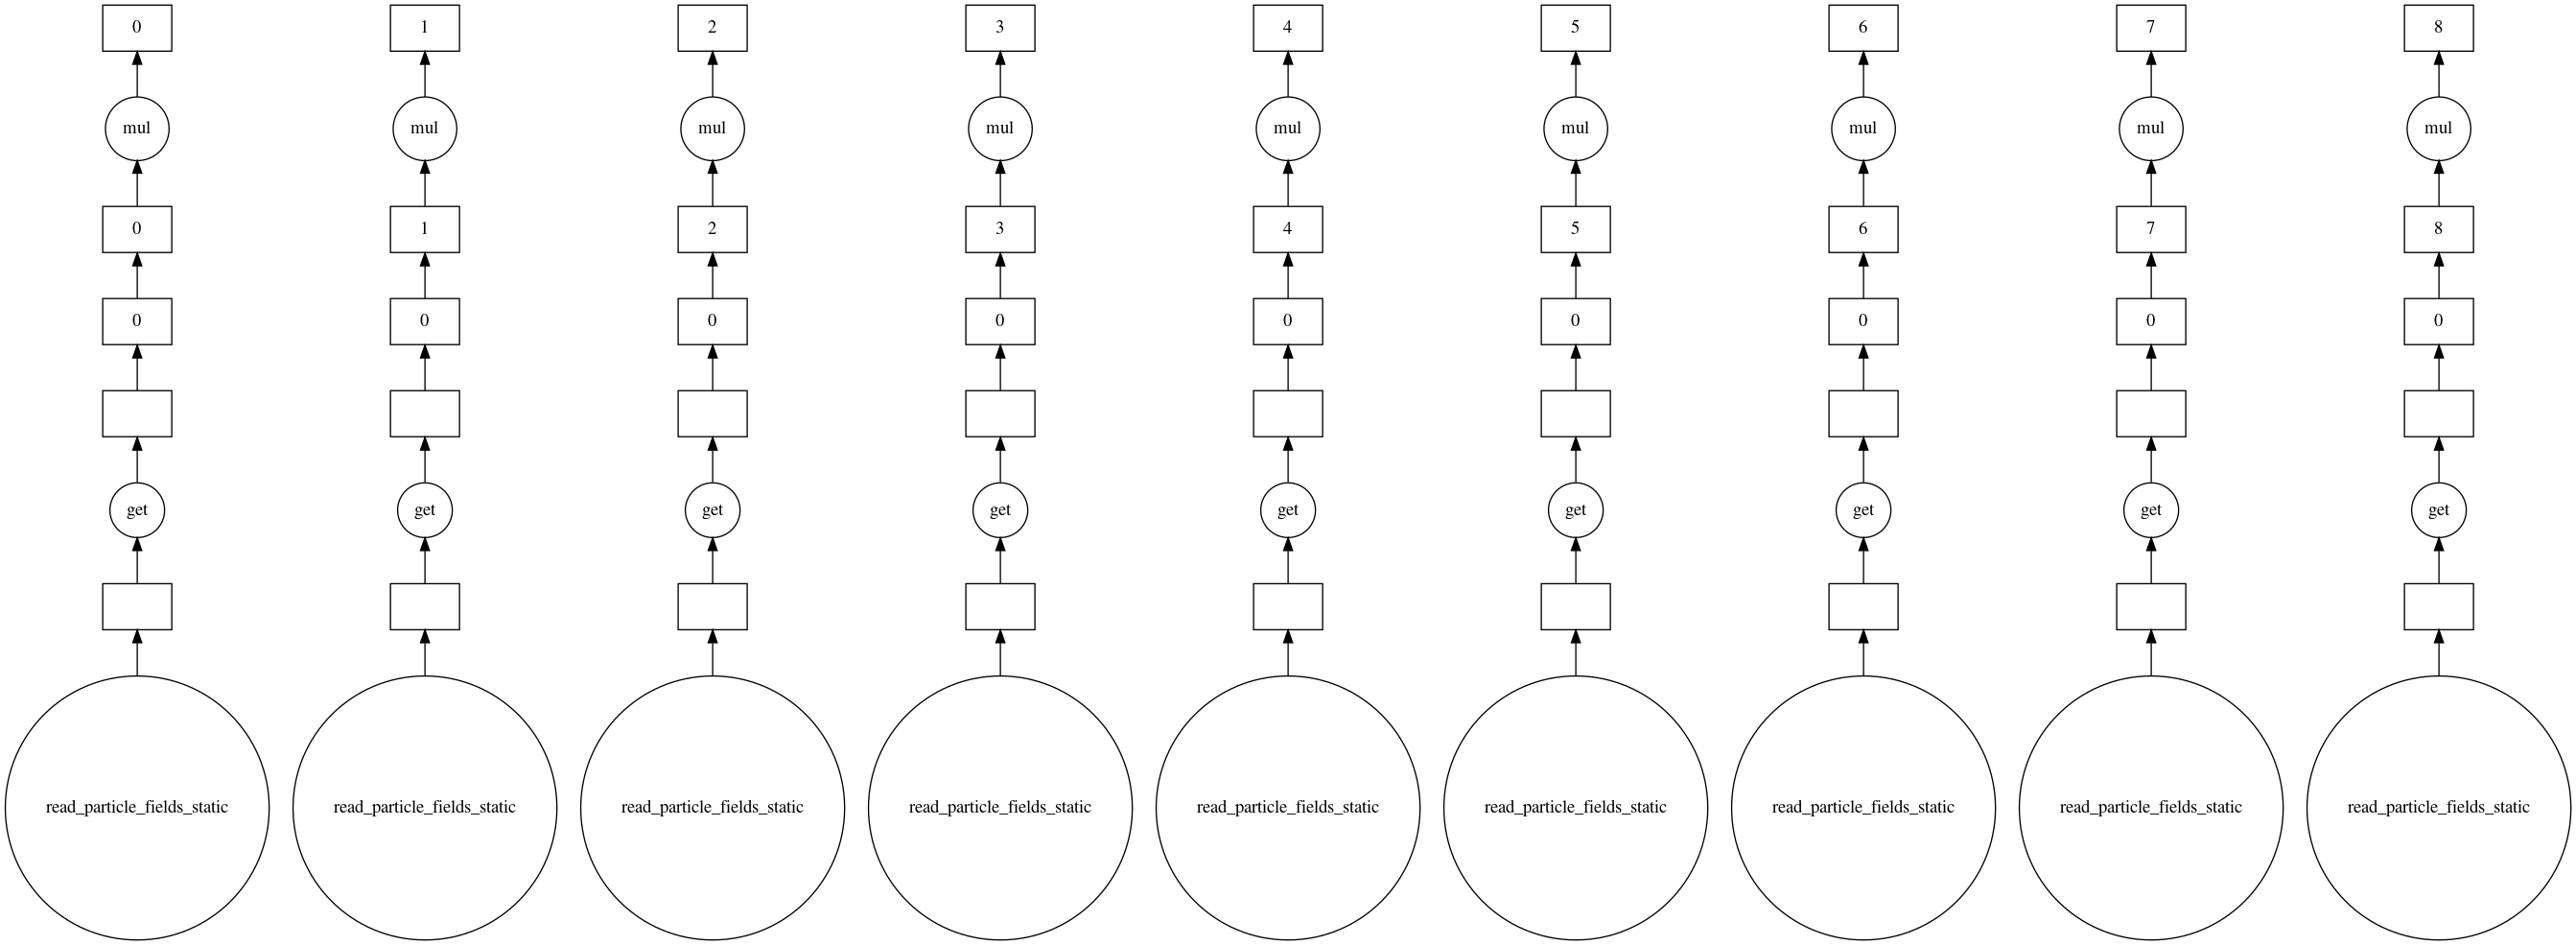

In [5]:
data.visualize()

Comparing to a sphere selection centered at the domain center:

In [12]:
sp = ds.sphere(ds.domain_center, ds.quan(0.25,'code_length'))
spData = sp[field]
spData

unyt_dask_array<mul, shape=(nan,), dtype=float64, chunksize=(nan,), chunktype=numpy.ndarray, units=code_mass/code_length**3>

we see we only have 7 chunks since the particle indexing has eliminated 2 of our chunks. We also see that we don't know the final shape yet, because we are applying an array mask within our graph. Our graph in this case is still nicely parallel but has some extra complications as it applies the selector object to each chunk (this gets skipped when reading in `all_data`), which requires reading the coordinates and particle smoothing length for our field:

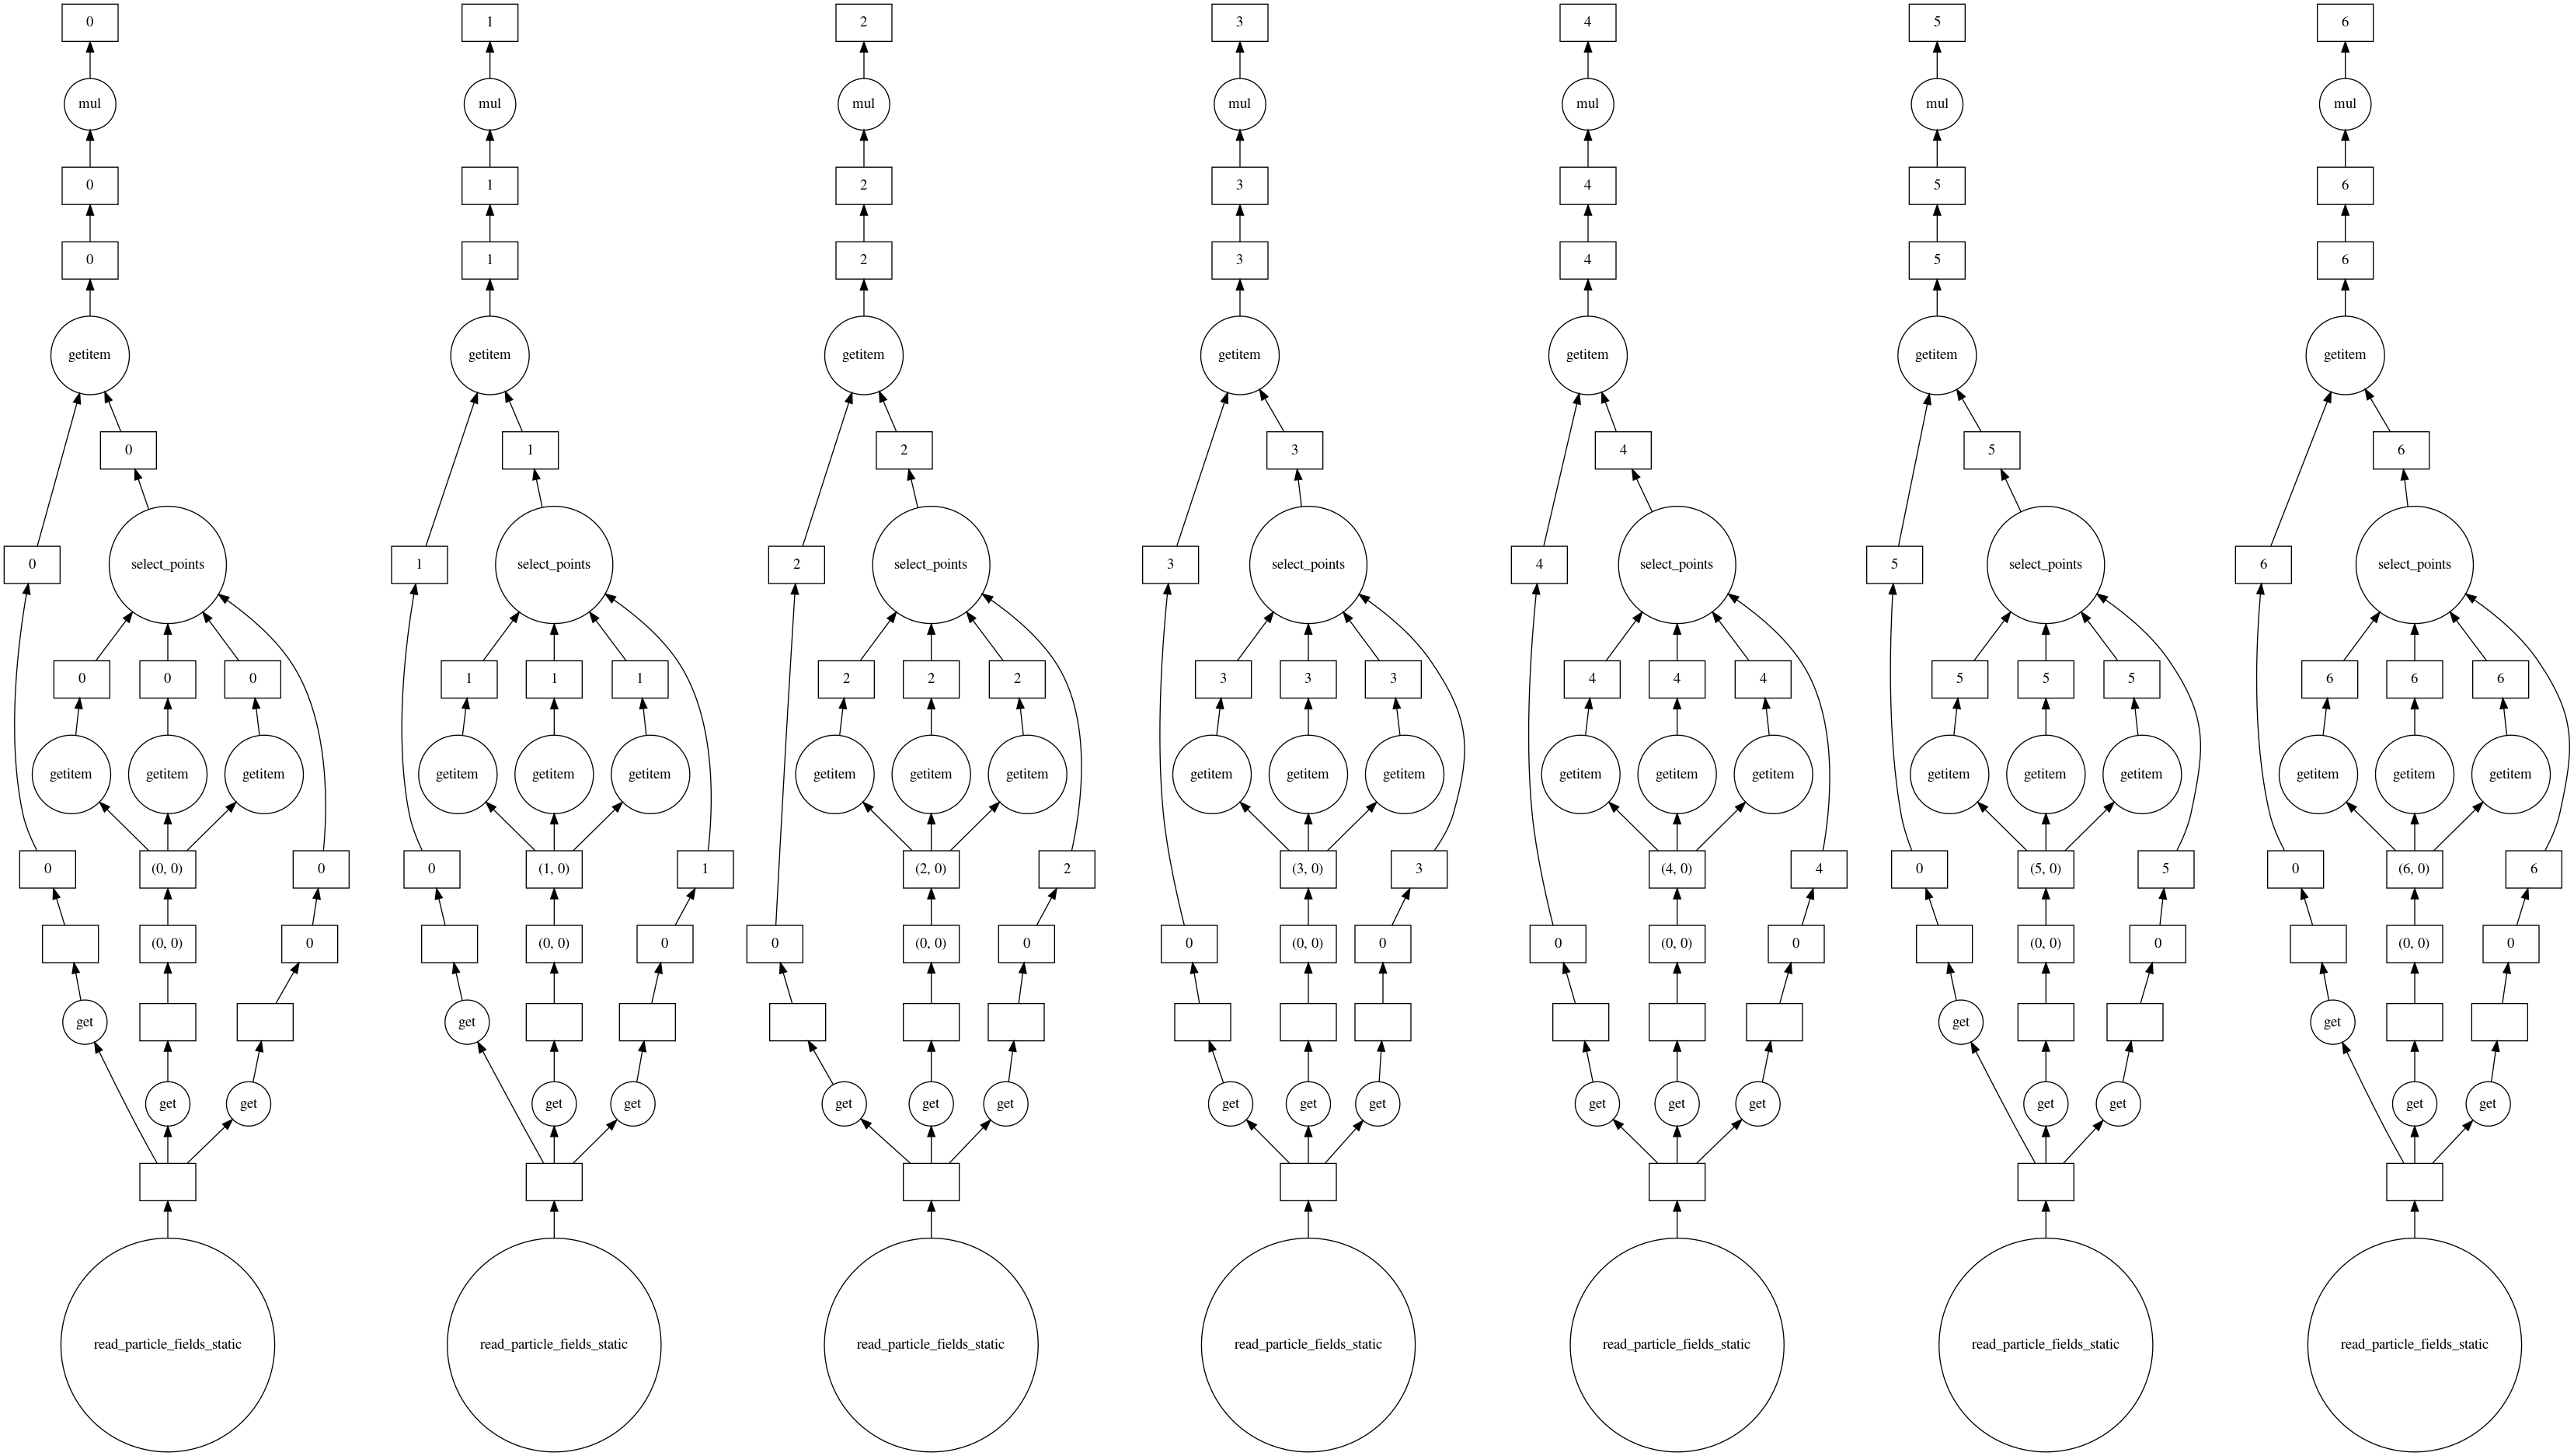

In [13]:
spData.visualize()

Comparing the execution time between the two, the selector application requires a bit of extra work:

In [15]:
%%timeit
ad = ds.all_data() 
data = ad[field]
_ = data.compute()

26.5 ms ± 5.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%%timeit
sp = ds.sphere(ds.domain_center, ds.quan(0.25,'code_length'))
spData = sp[field]
_ = spData.compute()

126 ms ± 2.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


These execution times are comparable to standard yt. After checking out `main` and re-running (restart the notebook, then run just these cells):

In [8]:
%%time
import warnings
warnings.filterwarnings("ignore")  # avoiding the ambiguous field deprecieation warnings for this frontend. 

import yt 
ds = yt.load_sample("snapshot_033")
ad = ds.all_data()

yt : [INFO     ] 2021-06-25 15:53:10,462 Sample dataset found in '/home/chris/hdd/data/yt_data/yt_sample_sets/snapshot_033/snap_033.0.hdf5'
yt : [INFO     ] 2021-06-25 15:53:10,580 Parameters: current_time              = 4.343952725460923e+17 s
yt : [INFO     ] 2021-06-25 15:53:10,581 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-06-25 15:53:10,581 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-06-25 15:53:10,582 Parameters: domain_right_edge         = [25. 25. 25.]
yt : [INFO     ] 2021-06-25 15:53:10,583 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-06-25 15:53:10,583 Parameters: current_redshift          = -4.811891664902035e-05
yt : [INFO     ] 2021-06-25 15:53:10,583 Parameters: omega_lambda              = 0.762
yt : [INFO     ] 2021-06-25 15:53:10,584 Parameters: omega_matter              = 0.238
yt : [INFO     ] 2021-06-25 15:53:10,584 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-06-25 15:53

CPU times: user 3.74 s, sys: 31.4 ms, total: 3.78 s
Wall time: 3.77 s


In [3]:
field = ("PartType0","Density")

In [4]:
%%timeit
ad = ds.all_data() 
data = ad[field]

12.8 ms ± 792 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
%%timeit
sp = ds.sphere(ds.domain_center, ds.quan(0.25,'code_length'))
spData = sp[field]

145 ms ± 3.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


So we see the Daskified all_data read is a tad slower while the selector application is a hair faster, but they're well within an acceptable range. If we spin up a dask Client, our read will happen in parallel:

In [1]:
from dask.distributed import Client

In [2]:
c = Client(n_workers = 4, threads_per_worker=1)

In [3]:
c

Client Scheduler: tcp://127.0.0.1:40239 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 33.24 GB


In [4]:
import yt 
ds = yt.load_sample("snapshot_033")

yt : [INFO     ] 2021-06-25 16:52:10,780 Files located at /home/chris/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.
yt : [INFO     ] 2021-06-25 16:52:10,782 Default to loading snap_033.0.hdf5 for snapshot_033 dataset
yt : [INFO     ] 2021-06-25 16:52:10,903 Parameters: current_time              = 4.343952725460923e+17 s
yt : [INFO     ] 2021-06-25 16:52:10,904 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-06-25 16:52:10,905 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-06-25 16:52:10,905 Parameters: domain_right_edge         = [25. 25. 25.]
yt : [INFO     ] 2021-06-25 16:52:10,906 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-06-25 16:52:10,906 Parameters: current_redshift          = -4.811891664902035e-05
yt : [INFO     ] 2021-06-25 16:52:10,907 Parameters: omega_lambda              = 0.762
yt : [INFO     ] 2021-06-25 16:52:10,908 Parameters: omega_matter              = 0.238
yt : [

In [6]:
field = ("PartType0","Density")

In [10]:
%%timeit
sp = ds.sphere(ds.domain_center, ds.quan(0.25,'code_length'))
spData = sp[field].compute()

419 ms ± 20.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
c.close()

So we see our parallel read is a bit slower. This isn't surprising as using multiple workers will incur some overhead communication. But in general these time differences are fairly small. 

In the `./code/` directory of [this poster's repository](https://github.com/chrishavlin/scipy2021_ytDaskening), we've written a number of scripts to measure the read time for a single field within a sphere for the `snapshot_033` dataset for all available methods, including MPI which is easier to test from command line. The following image shows a boxplot of the read time (excluding dataset loadtime and index build) for each method:

![](images/dask_read_times.png)

The test types are defined as follows:

|test type| description |
|---------|-------------|
|`dask` | default client configuration |
|`dask_mpi` | uses the dask-mpi scheduler with 4 workers |
|`dask_multiproc`| uses standard dask client with 4 workers, 1 thread per worker|
|`main_mpi`| main yt branch with MPI using 4 processors|
|`main_serial`| main yt branch, standard read|

The boxplot for each test type shows the median as a horizontal green line, the inter-quartile range (IQR) from the first to third quartile as a blue box, +/- 1.5 * IQR as the horizontal black lines and outliers as black circles.

50-60 tests were performed for each case. The results show that the daskified read is at least as fast as the version on main. The extra communication results in some larger outliers (black circles) but the minimum read times are on par or slightly faster in the dask test cases. The large spread on when executing on main with MPI is surprising and may be due to machine setup, but in any case the similar read times for all dask methods and the standard main read is encouraging. 

In the following section, we conduct similar tests for a daskified yt operation that uses the daskified particle reader.